In [2]:
!git clone https://github.com/JialongJiang/DSPIN.git
!pip install anndata
!pip install scanpy
!pip install line_profiler

Cloning into 'DSPIN'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (621/621), done.
remote: Compressing objects: 100% (588/588), done.
remote: Total 621 (delta 44), reused 599 (delta 27), pack-reused 0
Receiving objects: 100% (621/621), 31.01 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (44/44), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 972.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=950ab84249f0bc78287e015b959ef83d5ca609ec8b084bddeb

In [1]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

## Load data

In [2]:
data_folder = './data/HSC_simulation/'

In [3]:
cadata = ad.read_h5ad(data_folder + 'hsc_simulation_with_perturbations.h5ad')

In [4]:
cadata.var

,gene
0,Cebpa
1,EgrNab
2,Eklf
3,Fli1
4,Fog1
5,Gata1
6,Gata2
7,Gfi1
8,Pu1
9,Scl


In [54]:
gene_list = cadata.var['gene'].values
num_gene = len(gene_list)
samp_list = np.unique(cadata.obs['sample_id'])
aux_ind = [- 1, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 3, 4, 5, 6, 7, 8, 9]
samp_name = ['CONTROL'] + [gene + '\nknock-down' for gene in gene_list] + [gene + '\nactivation' for gene in gene_list]
samp_list_name = [samp_name[aux_ind[ii] + 1] for ii in range(num_gene * 2 + 1)]

## Test on Abstract Cases

In [ ]:
from util.dspin import DSPIN

In [63]:
# Reload the DSPIN class if you have made changes to the util/dspin.py file

from importlib import reload
import util.dspin  
reload(util.dspin)  
from util.dspin import DSPIN 

In [64]:
save_path = './test/'

In [65]:
a = DSPIN(cadata, save_path, num_spin=11, num_pool=11)

/Users/ygong/git/DSPIN-abstract/util/dspin.py:42: UserWarning: num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.
  warnings.warn("num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.")


In [66]:
a.set_onmf_summary(cadata.X)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 13.35it/s]


array([[-1., -1., -1., ..., -1.,  0., -1.],
       [-1., -1.,  0., ..., -1.,  1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 0., -1., -1., ...,  0., -1.,  0.],
       [-1., -1., -1., ..., -1., -1.,  1.],
       [-1.,  1., -1., ...,  0., -1.,  1.]])

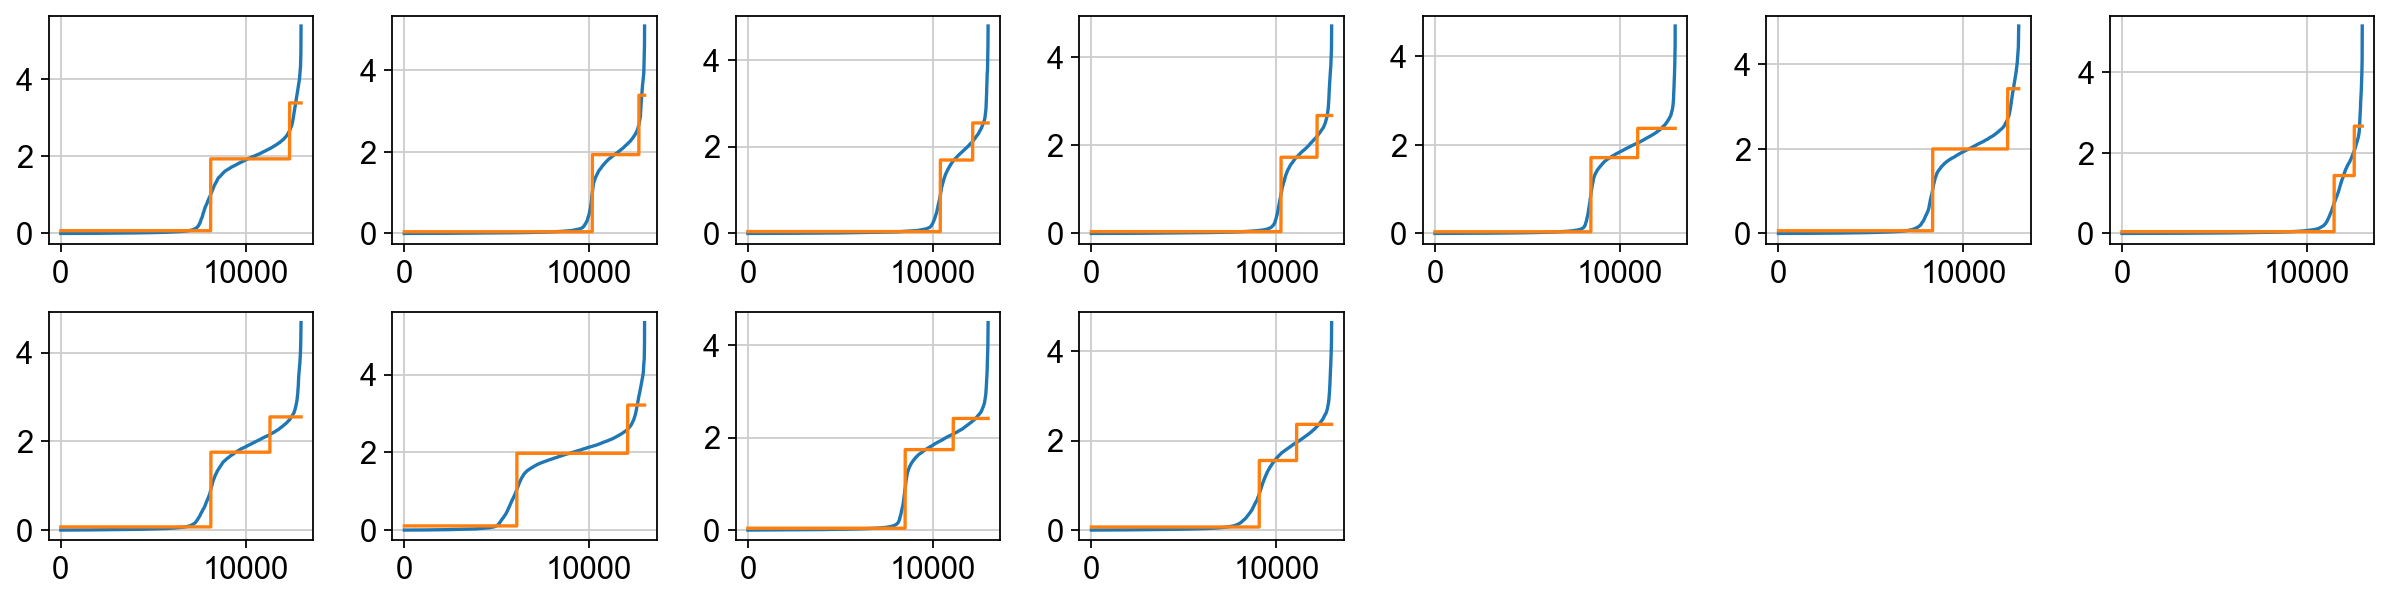

In [67]:
a.discretize()

In [68]:
a.cross_corr()

array([array([array([[ 0.92  ,  0.7835,  0.458 ,  0.3725, -0.175 ,  0.1365,  0.874 ,
                       0.889 ,  0.769 , -0.1215,  0.698 ],
                     [ 0.7835,  0.8775,  0.408 ,  0.3225, -0.226 ,  0.0855,  0.8225,
                       0.734 ,  0.777 , -0.1715,  0.8455],
                     [ 0.458 ,  0.408 ,  0.7885,  0.0325,  0.1175,  0.2375,  0.5215,
                       0.43  ,  0.317 ,  0.154 ,  0.3175],
                     [ 0.3725,  0.3225,  0.0325,  0.696 ,  0.166 ,  0.2385,  0.435 ,
                       0.3445,  0.2315,  0.179 ,  0.2335],
                     [-0.175 , -0.226 ,  0.1175,  0.166 ,  0.5945,  0.2475, -0.0975,
                      -0.1925, -0.316 ,  0.417 , -0.3085],
                     [ 0.1365,  0.0855,  0.2375,  0.2385,  0.2475,  0.282 ,  0.22  ,
                       0.1165, -0.0055,  0.262 , -0.0045],
                     [ 0.874 ,  0.8225,  0.5215,  0.435 , -0.0975,  0.22  ,  0.9685,
                       0.8405,  0.7315, -0.0485,  0

In [69]:
a.network_infer()

Progress: 10, Network gradient: 9.279274
Progress: 15, Network gradient: 2.131055
Progress: 20, Network gradient: 3.276036
Progress: 25, Network gradient: 1.265859
Progress: 30, Network gradient: 0.648018
Progress: 35, Network gradient: 0.601287
Progress: 40, Network gradient: 0.354185
Progress: 45, Network gradient: 0.305591
Progress: 50, Network gradient: 0.154334
Progress: 55, Network gradient: 0.149767
Progress: 60, Network gradient: 0.120121
Progress: 65, Network gradient: 0.100943
Progress: 70, Network gradient: 0.090225
Progress: 75, Network gradient: 0.080508
Progress: 80, Network gradient: 0.071155
Progress: 85, Network gradient: 0.063496
Progress: 90, Network gradient: 0.057666
Progress: 95, Network gradient: 0.053082
Progress: 100, Network gradient: 0.048809


In [70]:
cur_j = a.network

In [71]:
cur_h = a.responses

In [58]:
num_spin = 11

In [59]:
spin_order

array([ 2,  4,  5,  9,  1,  8, 10,  0,  7,  3,  6])

In [60]:
j_ref

array([[ 1.,  0.,  0.,  0., -1., -1.,  0.,  1.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  1.],
       [ 0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  1.,  1.,  1.,  1.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  1.,  0., -1.,  0.,  0.],
       [ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  1., -1.,  1.],
       [-1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.]])

Text(0.5, 1.0, 'D-SPIN')

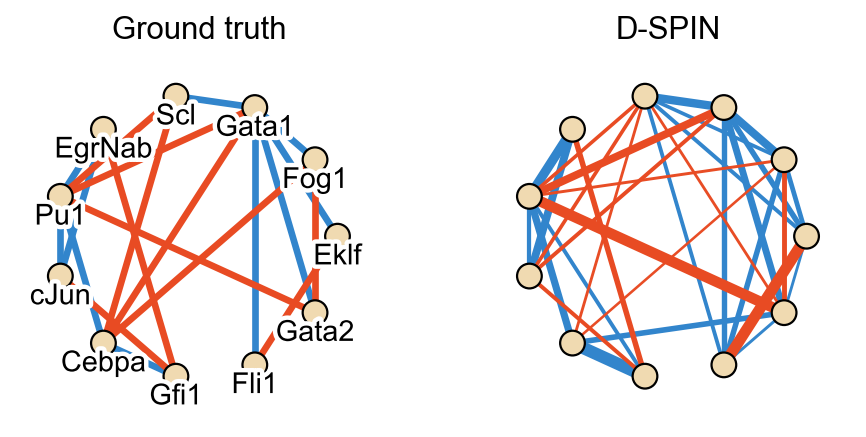

In [72]:
sc.set_figure_params(figsize=[3.2, 3])

nodesz = 2
linewz = 1.5
node_color = ['#f0dab1'] * num_spin
node_label = np.array(list(gene_list[spin_order]))

fig, grid = sc.pl._tools._panel_grid(0.1, 0.1, ncols=2, num_panels=2)

G = nx.from_numpy_array(j_ref[spin_order, :][:, spin_order] * 2)
spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])
pos = nx.circular_layout(G)

ax = plt.subplot(grid[0])
ax = plot_jmat_network()

path_effect = [patheffects.withStroke(linewidth=4, foreground='w')]
for ii in range(num_spin):
    text = plt.text(pos[ii][0], pos[ii][1] - 0.15, node_label[ii], fontsize=13, color='k', ha='center', va='center')
    text.set_path_effects(path_effect)
ax.set_title('Ground truth')


ax = plt.subplot(grid[1])
cur_j_filt = cur_j.copy()
cur_j_filt[np.abs(cur_j_filt) < np.percentile(np.abs(cur_j_filt), 40)] = 0
G = nx.from_numpy_array(cur_j_filt[spin_order, :][:, spin_order])
ax = plot_jmat_network()
ax.set_title('D-SPIN')

## Visualize simulation of the HSC network with perturbations

In [56]:
from sklearn.cluster import KMeans

kmeans_label = KMeans(n_clusters=7, random_state=0).fit_predict(cadata.X)
cadata.obs['kmeans'] = kmeans_label

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


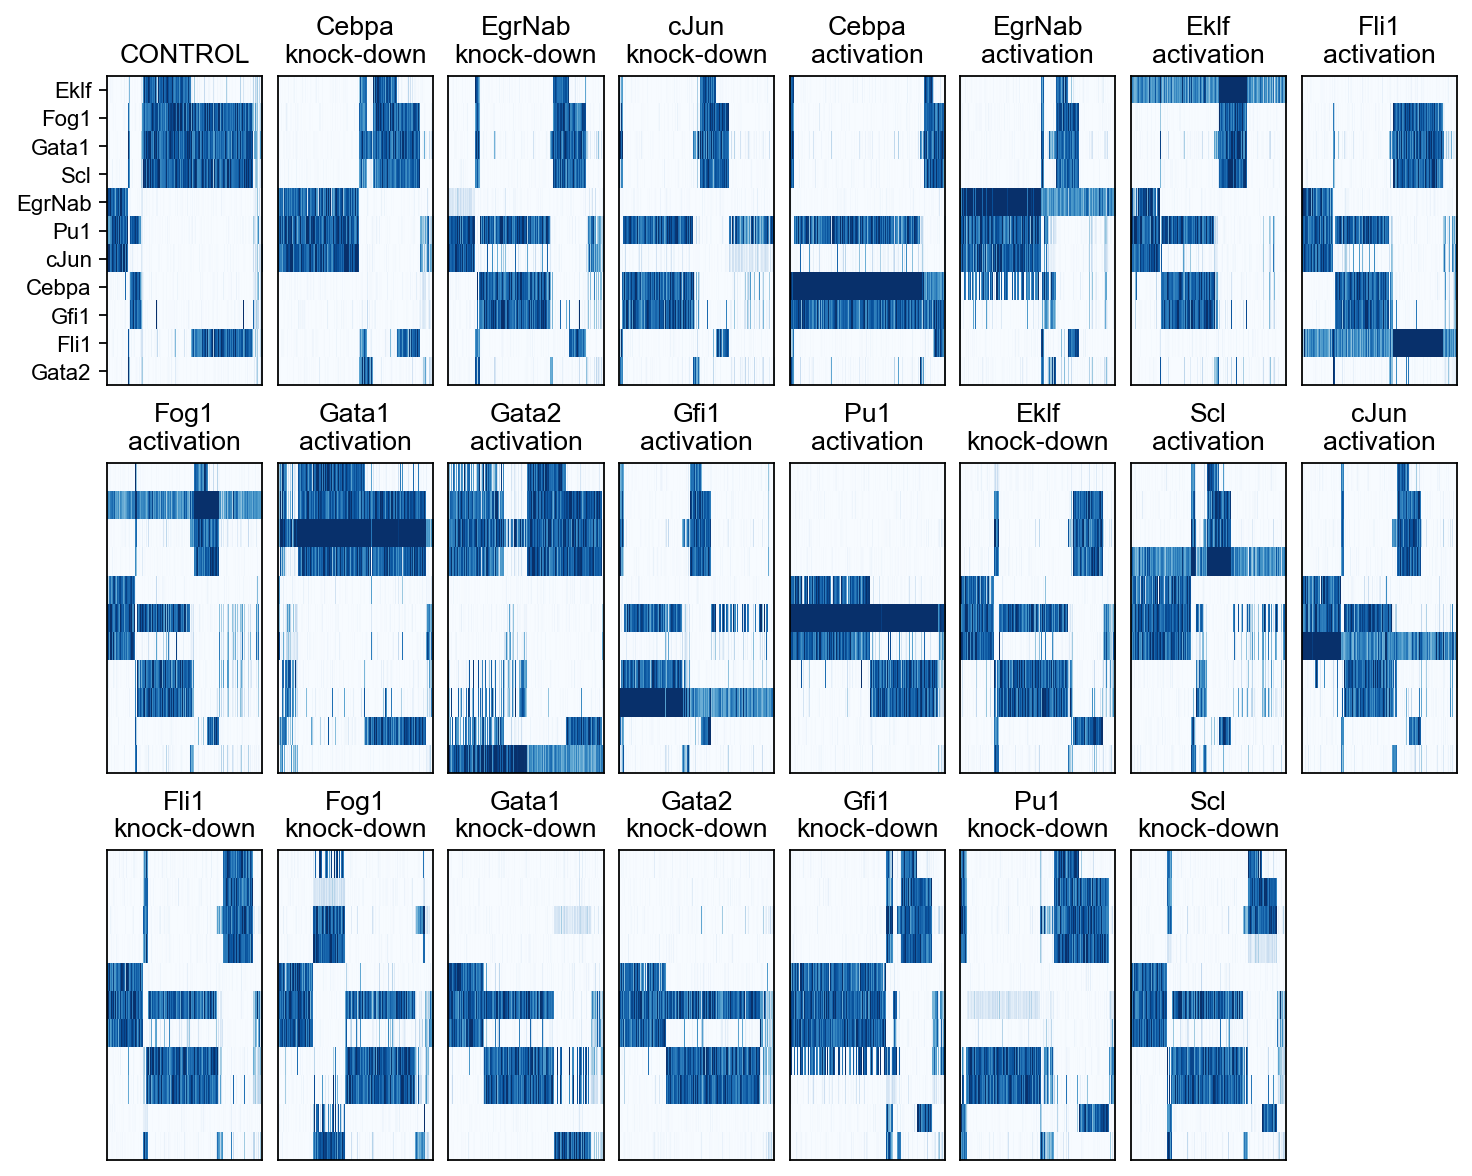

In [57]:
plot_heatmap_sample = samp_list

sc.set_figure_params(figsize=[1.2, 2.7])
fig, grid = sc.pl._tools._panel_grid(0.25, 0.1, ncols=8, num_panels=len(plot_heatmap_sample))
spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])

for ii, samp in enumerate(plot_heatmap_sample):
    ax = plt.subplot(grid[ii])
    cur_filt = (cadata.obs['sample_id'] == samp)
    samp_order = np.argsort(cadata.obs['kmeans'][cur_filt])
    plt.imshow(cadata.X[cur_filt, :].T[:, samp_order][spin_order, :], cmap='Blues', aspect='auto', interpolation='none', vmin=0, vmax=2.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(samp_list_name[ii], fontsize=12)

ax = plt.subplot(grid[0])
plt.yticks(np.arange(cadata.shape[1]), cadata.var['gene'][spin_order], fontsize=10)
plt.grid()

## Discretize and compute the cross-correlation of each condition

100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


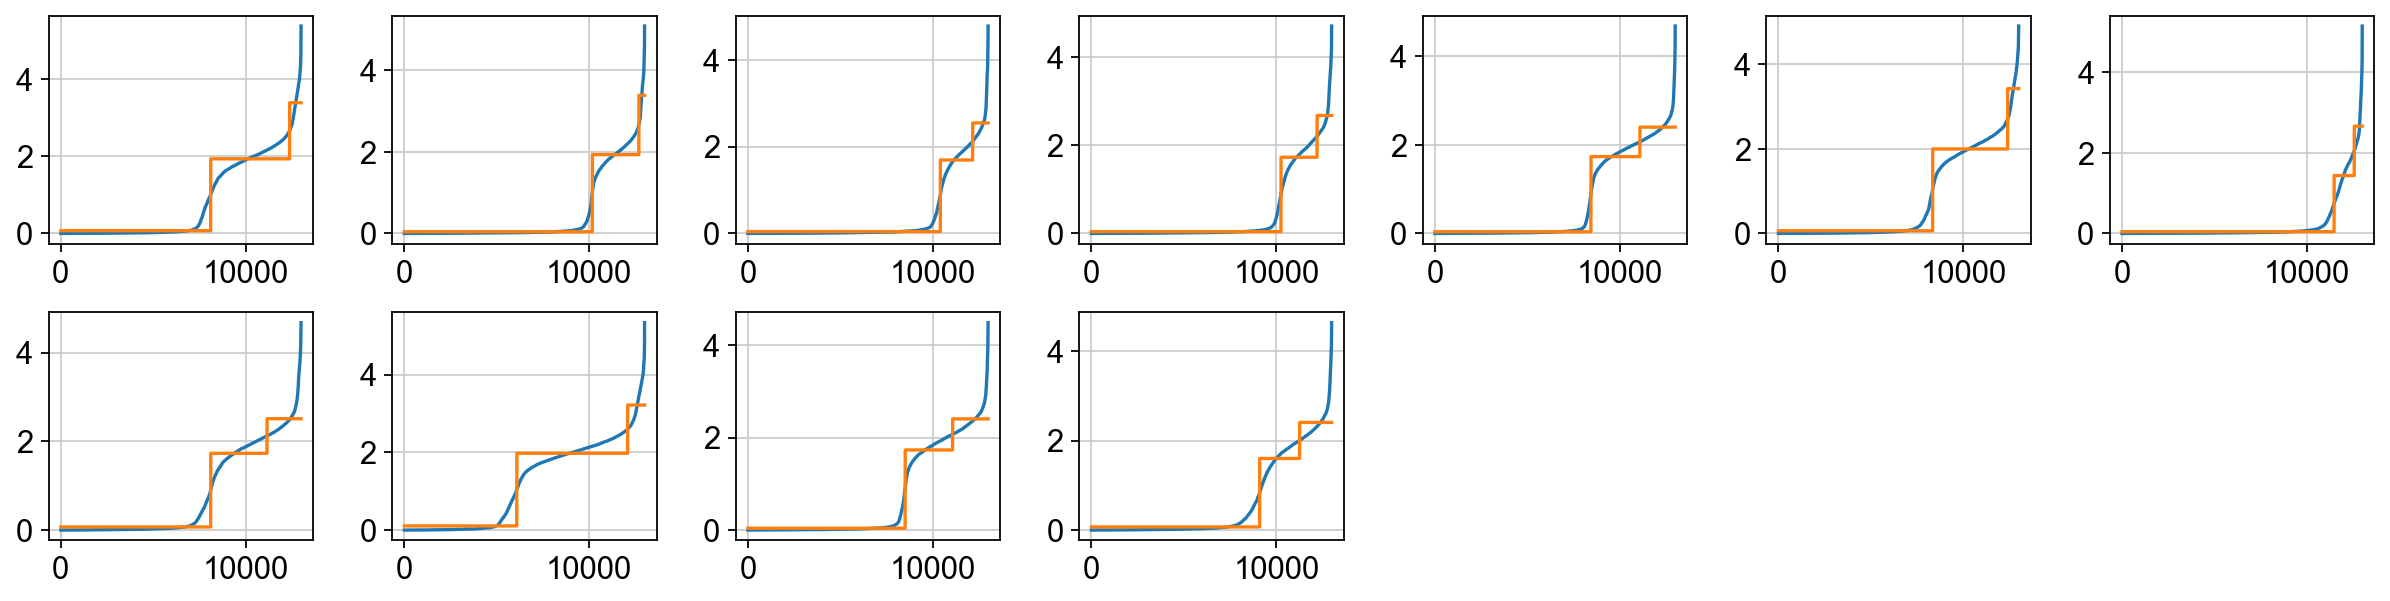

In [41]:
onmf_rep_ori = cadata.X
num_spin = onmf_rep_ori.shape[1]

sc.set_figure_params(figsize=[2, 2])
fig, grid = sc.pl._tools._panel_grid(0.3, 0.3, ncols=7, num_panels=num_spin)
onmf_rep_tri = np.zeros(onmf_rep_ori.shape)
rec_kmeans = np.zeros(num_spin, dtype=object)

for ii in tqdm(range(num_spin)):
    ax = plt.subplot(grid[ii])

    km_fit = KMeans(n_clusters=3, n_init=10)
    km_fit.fit(onmf_rep_ori[:, ii].reshape(- 1, 1))
    plt.plot(np.sort(onmf_rep_ori[:, ii]));
    plt.plot(np.sort(km_fit.cluster_centers_[km_fit.labels_].reshape(- 1)));

    label_ord = np.argsort(km_fit.cluster_centers_.reshape(- 1))
    onmf_rep_tri[:, ii] = (km_fit.labels_ == label_ord[0]) * (-1) + (km_fit.labels_ == label_ord[2]) * 1
    rec_kmeans[ii] = km_fit

In [15]:
onmf_rep_ori.shape

(13000, 11)

In [16]:
from DSPIN.util.compute import sample_corr_mean

In [17]:
raw_data, samp_list = sample_corr_mean(cadata.obs['sample_id'], onmf_rep_tri)
filen = data_folder + 'dspin/data_raw.mat'

savemat(filen, {'raw_data': raw_data, 'network_subset': list(range(len(samp_list))), 'samp_list': samp_list})

In [18]:
raw_data.shape

(23,)

In [62]:
cadata.obs['sample_id'].value_counts()

Control       2000
Perturb_11     500
Perturb_20     500
Perturb_19     500
Perturb_18     500
Perturb_17     500
Perturb_16     500
Perturb_15     500
Perturb_14     500
Perturb_13     500
Perturb_12     500
Perturb_10     500
Perturb_0      500
Perturb_9      500
Perturb_8      500
Perturb_7      500
Perturb_6      500
Perturb_5      500
Perturb_4      500
Perturb_3      500
Perturb_2      500
Perturb_1      500
Perturb_21     500
Name: sample_id, dtype: int64

## Setting hyperparameters

In [20]:
cdata = raw_data

num_spin = cdata[0][0].shape[0]
num_samp = len(cdata)
rec_all_corr = np.zeros((num_spin, num_spin, num_samp))
rec_all_mean = np.zeros((num_spin, num_samp))

for ii in range(num_samp):
    rec_all_corr[:, :, ii] = cdata[ii][0]
    rec_all_mean[:, ii] = cdata[ii][1].flatten()

cur_j = np.zeros((num_spin, num_spin))
cur_h = np.zeros((num_spin, num_samp))

In [21]:
data_dir = data_folder + 'dspin_python/'

train_dat = {'cur_j': cur_j, 'cur_h': cur_h, 'epoch': 200, 'spin_thres': 16,
             'stepsz': 0.2, 'dropout': 0, 'counter': 1,
             'samplingsz': 5e7, 'samplingmix': 1e3, 'rec_gap': 10}
train_dat['task_name'] = data_dir + 'train_log'

In [21]:
cdata[0][0].shape

(11, 11)

In [ ]:
import os
dir_list = [data_dir, data_dir + 'train_log']
for directory in dir_list:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Infer the network

In [ ]:
from DSPIN.util.compute import sample_corr_mean, wthresh, para_moments, learn_jmat_adam
import scipy.io as sio

In [ ]:
cur_j, cur_h = learn_jmat_adam(rec_all_corr, rec_all_mean, train_dat)

Progress: 10, Network gradient: 10.782047
Progress: 15, Network gradient: 9.990119
Progress: 20, Network gradient: 4.713897
Progress: 25, Network gradient: 4.429163
Progress: 30, Network gradient: 2.023955
Progress: 35, Network gradient: 1.006383
Progress: 40, Network gradient: 0.897292
Progress: 45, Network gradient: 0.606291
Progress: 50, Network gradient: 0.503962
Progress: 55, Network gradient: 0.296060
Progress: 60, Network gradient: 0.310062
Progress: 65, Network gradient: 0.229870
Progress: 70, Network gradient: 0.222020
Progress: 75, Network gradient: 0.182874
Progress: 80, Network gradient: 0.170927
Progress: 85, Network gradient: 0.151998
Progress: 90, Network gradient: 0.136192
Progress: 95, Network gradient: 0.124337
Progress: 100, Network gradient: 0.112564


## Compare the inferred network with the ground truth

In [51]:
import re

ref_network = pd.read_csv(data_folder + '/refNetwork.csv')

gene_list = cadata.var['gene']
j_mat = np.zeros([len(gene_list), len(gene_list)])

for row in ref_network.itertuples():
    gene1 = row.Gene1
    gene2 = row.Gene2
    interaction = row.Type
    if interaction == '+':
        j_mat[gene_list == gene1, gene_list == gene2] = 1
    elif interaction == '-':
        j_mat[gene_list == gene1, gene_list == gene2] = -1

j_mat[(j_mat == - 1) & (j_mat.T == 1)] = 1
j_mat += j_mat.T
j_mat = np.sign(j_mat)

j_ref = j_mat.copy()

In [52]:
import networkx as nx
import matplotlib.patheffects as patheffects

def plot_jmat_network():

    self_loops = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(self_loops)

    eposi= [(u, v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0]
    wposi= np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] > 0])

    enega = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0]
    wnega = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] < 0])

    col1 = '#f0dab1'
    # nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=col1, edgecolors='None')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=node_color, edgecolors='k')

    sig_fun = lambda xx : (1 / (1 + np.exp(- 5 * (xx + cc))))
    cc = np.max(np.abs(j_mat)) / 10
    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=eposi, width=linewz * wposi,
                            edge_color='#3285CC', alpha=sig_fun(wposi))

    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=enega, width=- linewz * wnega,
                            edge_color='#E84B23', alpha=sig_fun(- wnega))

    margin = 0.2
    plt.margins(x=0.1, y=0.1)

    ax.set_axis_off()
    ax.set_aspect('equal')
    return ax

Text(0.5, 1.0, 'D-SPIN')

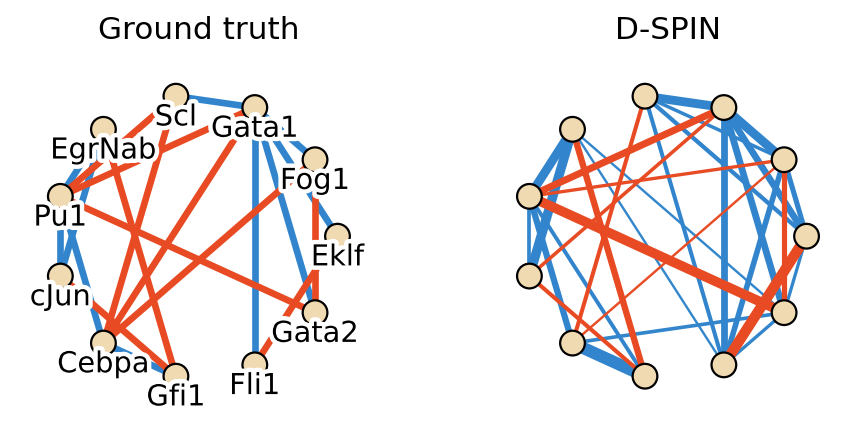

In [ ]:
sc.set_figure_params(figsize=[3.2, 3])

nodesz = 2
linewz = 1.5
node_color = ['#f0dab1'] * num_spin
node_label = np.array(list(gene_list[spin_order]))

fig, grid = sc.pl._tools._panel_grid(0.1, 0.1, ncols=2, num_panels=2)

G = nx.from_numpy_array(j_ref[spin_order, :][:, spin_order] * 2)
spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])
pos = nx.circular_layout(G)

ax = plt.subplot(grid[0])
ax = plot_jmat_network()

path_effect = [patheffects.withStroke(linewidth=4, foreground='w')]
for ii in range(num_spin):
    text = plt.text(pos[ii][0], pos[ii][1] - 0.15, node_label[ii], fontsize=13, color='k', ha='center', va='center')
    text.set_path_effects(path_effect)
ax.set_title('Ground truth')


ax = plt.subplot(grid[1])
cur_j_filt = cur_j.copy()
cur_j_filt[np.abs(cur_j_filt) < np.percentile(np.abs(cur_j_filt), 40)] = 0
G = nx.from_numpy_array(cur_j_filt[spin_order, :][:, spin_order])
ax = plot_jmat_network()
ax.set_title('D-SPIN')

## Compute accuracy of the inferred network

In [ ]:
def precision_recall_curve(j_ref, cur_j):
    num_spin = j_ref.shape[0]
    max_k = int(num_spin * (num_spin - 1) / 2)

    j_ref = np.triu(j_ref, k=1)
    cur_j = np.maximum(np.abs(cur_j), np.abs(cur_j).T)
    cur_j = np.triu(cur_j, k=1)

    # Flatten and sort the upper triangular portions of the matrices
    ref_indices = np.argsort(np.abs(j_ref), axis=None)[::-1]
    cur_indices = np.argsort(np.abs(cur_j), axis=None)[::-1]

    ref_values = np.sort(np.abs(j_ref), axis=None)[::-1]
    cur_values = np.sort(np.abs(cur_j), axis=None)[::-1]

    ref_indices = ref_indices[ref_values > 0]
    cur_indices = cur_indices[cur_values > 0]

    # Compute whether each inferred edge is in the list by order
    edge_in_list = np.isin(cur_indices, ref_indices)
    correct_predictions_cumsum = np.cumsum(edge_in_list)

    precision_values = correct_predictions_cumsum / np.arange(1, max_k+1)
    recall_values = correct_predictions_cumsum / len(ref_indices)

    return precision_values, recall_values

In [ ]:
precision, recall = precision_recall_curve(j_ref, cur_j)
print('Top 10 accuracy %.2f , Top 15 accuracy %.2f, Top 20 accuracy %.2f' % (precision[9], precision[14], precision[19]))

Top 10 accuracy 1.00 , Top 15 accuracy 0.93, Top 20 accuracy 0.80
